In [66]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2506412033217337929
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701340352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2709907321652631463
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [67]:
# all import
import json
import zipfile
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, Activation


In [ ]:
# https://blog.toright.com/posts/6817/%E5%A6%82%E4%BD%95%E5%9C%A8-colab-%E4%B8%AD%E9%80%8F%E9%81%8E-kaggle-api-%E4%B8%8B%E8%BC%89%E8%B3%87%E6%96%99%E9%9B%86.html
api_token = {"username":"***","key":"***"}
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle competitions download -c dogs-vs-cats
 
!ls /kaggle

 97% 264M/271M [00:05<00:00, 75.0MB/s]
100% 271M/271M [00:05<00:00, 55.5MB/s]
 99% 539M/543M [00:09<00:00, 38.9MB/s]
100% 543M/543M [00:09<00:00, 62.0MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 75.5MB/s]
sampleSubmission.csv  test1.zip  train.zip


In [ ]:
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall()
    print('unzip!')


if __name__ == '__main__':
    file_path_train = '../kaggle/train.zip'
    file_path_test = '../kaggle/test1.zip'
    zip_list(file_path_train)
    zip_list(file_path_test)

unzip!
unzip!


In [ ]:
# https://stackoverflow.com/questions/52265978/how-to-delete-a-locally-uploaded-file-on-google-colab
%rm -rf /kaggle/test1.zip
%rm -rf /kaggle/train.zip

In [68]:
test_images_dir = "../kaggle/test1/"
train_images_dir= "../kaggle/train/"
sample_sub_path = "../kaggle/sampleSubmission.csv"

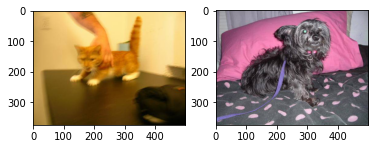

In [69]:
for i in range(1,3):
  plt.subplot(1,2,i)
  if i % 2 == 1:   
    filename = train_images_dir + 'cat.0.jpg'
  else:
    filename = train_images_dir + 'dog.0.jpg'
  image = imread(filename)
  plt.imshow(image)

plt.show()

In [70]:
submit_example = pd.read_csv(sample_sub_path)
submit_example.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [71]:
# 參考: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/
# train
imagedir = os.listdir(train_images_dir)
labels = []
for filename in imagedir:
  if filename.startswith('cat'):
    labels.append('cat')
  else:
    labels.append('dog')

# 使用 pandas 套件的 DataFrame() 方法將一個 dictionary 的資料結構轉換成 data frame
df = pd.DataFrame({"file":imagedir, "label":labels})

print(df.head())
print(df.tail())

# test
test_images_path = os.listdir(test_images_dir)
test_df = pd.DataFrame({'file':test_images_path})
print(test_df.head())

            file label
0  dog.10680.jpg   dog
1   dog.9535.jpg   dog
2   cat.5840.jpg   cat
3   dog.9443.jpg   dog
4  dog.10890.jpg   dog
                file label
24995   cat.3753.jpg   cat
24996   cat.2354.jpg   cat
24997  cat.11291.jpg   cat
24998    cat.882.jpg   cat
24999   dog.8025.jpg   dog
       file
0  7255.jpg
1  7113.jpg
2  8581.jpg
3  1383.jpg
4  2914.jpg


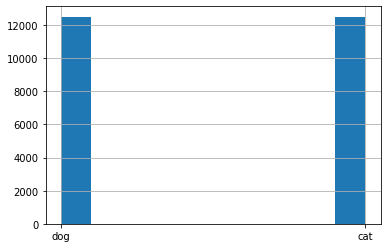

In [72]:
# 制作DataFrame的直方图
df['label'].hist()

Text(0.5, 1.0, 'Class:dog')

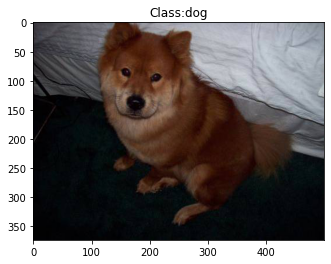

In [73]:
img_path = train_images_dir + df['file'][0]
label = df['label'][0]

img = imread(img_path)
plt.imshow(img)

plt.imshow(img)
plt.title("Class:"+label)

In [11]:
df.shape

(25000, 2)

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.15)
print("Training set:", train_df.shape)
print("Validation set:", valid_df.shape)

Training set: (21250, 2)
Validation set: (3750, 2)


### ImageDataGenerator
#### data preprocessing
當前資料是以JPEG檔案的形式儲存在硬碟中，預處理步驟如下：
* 讀取影象檔案
* 將JPEG檔案解碼為RGB畫素網格
* 將畫素網格轉化為浮點數張量
* 將畫素值縮放到0~1區間

Keras提供自動完成preprocessing的工具：keras.preprocessing.image ImageDataGenerator類

```
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                train_dir, # 目標目錄
                target_size=(150, 150), # 所有影象調整為150x150
                batch_size=20,
                class_mode='binary') # 二進位制標籤，我們用了binary_crossentropy損失函式
```
#### Data augmentation（資料增強）

```
# 資料增強增加學習樣本
datagen = ImageDataGenerator(
    rotation_range=40, # 角度值，0~180，影象旋轉
    width_shift_range=0.2, # 水平平移，相對總寬度的比例
    height_shift_range=0.2, # 垂直平移，相對總高度的比例
    shear_range=0.2, # 隨機錯切換角度
    zoom_range=0.2, # 隨機縮放範圍
    horizontal_flip=True, # 一半影象水平翻轉
    fill_mode='nearest' # 填充新建立畫素的方法
)
```
from: https://www.itread01.com/content/1546542668.html

In [74]:
# https://www.itread01.com/content/1546542668.html
train_gen = ImageDataGenerator(rescale = 1.0/255.0,
                horizontal_flip = True,
                vertical_flip   = True,
                fill_mode = 'nearest',
                rotation_range = 10,
                width_shift_range = 0.2,
                height_shift_range= 0.2,
                shear_range= 0.15,
                brightness_range= (.5,1.2),
                zoom_range = 0.2)

train_gen = train_gen.flow_from_dataframe(train_df,
                      directory = train_images_dir,
                      x_col = 'file', 
                      y_col = 'label', 
                      target_size =(128, 128), 
                      class_mode = 'categorical',  # one hot encoded
                      batch_size = 32, 
                      color_mode = 'rgb', 
                      shuffle = True)

valid_gen = ImageDataGenerator(rescale=1./255)
valid_gen = valid_gen.flow_from_dataframe(valid_df, 
                      directory = train_images_dir,
                      x_col='file',
                      y_col='label',
                      target_size =(128, 128),
                      class_mode='categorical',
                      batch_size=32)

test_gen = ImageDataGenerator(rescale=1.0/255.0)
test_gen = test_gen.flow_from_dataframe(test_df, 
                    directory=test_images_dir, 
                    x_col='file', 
                    y_col=None,
                    class_mode=None,
                    target_size=(128, 128),
                    color_mode="rgb",
                    shuffle = False)

Found 21250 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


(32, 128, 128, 3)


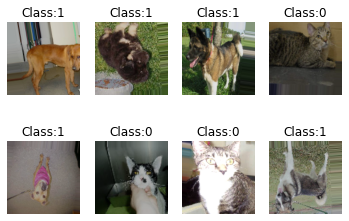

In [75]:
def showImage(image_gen):
  for x_gens, y_gens in image_gen:
    print(x_gens.shape)
    x_gen_shape = x_gens.shape[1:]
    i = 0
    for sample_img, sample_class in zip(x_gens, y_gens):      
      plt.subplot(2,4,i+1)
      plt.title(f'Class:{np.argmax(sample_class)}')
      plt.axis('off')
      plt.imshow(sample_img)
      
      i += 1
      
      if i >= 8:
        break
    break

  plt.show()

showImage(train_gen)

In [76]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, input_shape=x_gen_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, input_shape=x_gen_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, input_shape=x_gen_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_12 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 64)       

In [77]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
epochs = 30
history = model.fit(train_gen, 
          # steps_per_epoch = len(train_df)//32, 
          epochs = epochs, 
          validation_data = valid_gen, 
          # validation_steps = len(valid_df)//BATCH_SIZE
          )

Epoch 1/30
665/665 [==============================] - 145s 217ms/step - loss: 0.8008 - accuracy: 0.5688 - val_loss: 0.6218 - val_accuracy: 0.6421
Epoch 2/30
665/665 [==============================] - 143s 214ms/step - loss: 0.6402 - accuracy: 0.6337 - val_loss: 0.6435 - val_accuracy: 0.6453
Epoch 3/30
665/665 [==============================] - 139s 210ms/step - loss: 0.6076 - accuracy: 0.6667 - val_loss: 0.5814 - val_accuracy: 0.6915
Epoch 4/30
665/665 [==============================] - 139s 208ms/step - loss: 0.5969 - accuracy: 0.6756 - val_loss: 0.6072 - val_accuracy: 0.6891
Epoch 5/30
665/665 [==============================] - 138s 207ms/step - loss: 0.5607 - accuracy: 0.7105 - val_loss: 0.5084 - val_accuracy: 0.7499
Epoch 6/30
665/665 [==============================] - 137s 205ms/step - loss: 0.5446 - accuracy: 0.7212 - val_loss: 0.6807 - val_accuracy: 0.6672
Epoch 7/30
665/665 [==============================] - 136s 204ms/step - loss: 0.5349 - accuracy: 0.7261 - val_loss: 0.7159 -

###  EarlyStopping
patience：能夠容忍多少個epoch內都沒有improvement

from: https://medium.com/ai%E5%8F%8D%E6%96%97%E5%9F%8E/learning-model-earlystopping%E4%BB%8B%E7%B4%B9-%E8%BD%89%E9%8C%84-f364f4f220fb

### ReduceLROnPlateau



* monitor：監測的值，可以是accuracy，val_loss,val_accuracy
* factor：縮放學習率的值，學習率將以lr = lr*factor的形式被減少
* patience：當patience個epoch過去而模型性能不提升時，學習率減少的動作會被觸发
* mode：‘auto’，‘min’，‘max’之一 默認‘auto’就行
* epsilon：閾值，用來確定是否進入檢測值的“平原區”
* cooldown：學習率減少後，會經過cooldown個epoch才重新進行正常操作
* min_lr：學習率最小值，能縮小到的下限

from: https://blog.csdn.net/weixin_44048809/article/details/105711356

```
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                      patience=2, 
                      verbose=1, 
                      factor=0.5, 
                      min_lr=0.0001)
                      factor=0.5, 
                      min_lr=0.0001)
```


In [79]:
model.save_weights('../kaggle/weights/weights_cat_dog.h5')

In [80]:
print(history.history.keys())
print("Acc:", history.history['accuracy'][-1])
print("Val Acc:", history.history['val_accuracy'][-1])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Acc: 0.824470579624176
Val Acc: 0.8533333539962769


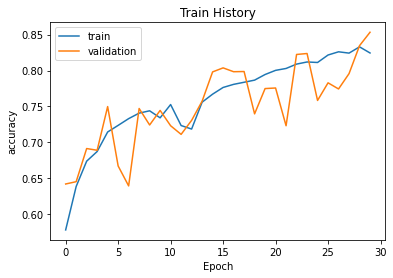

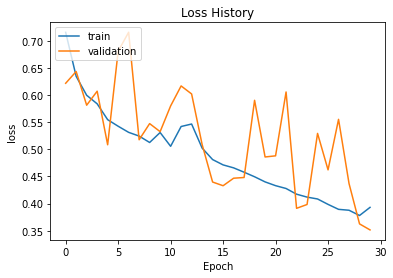

In [81]:
def show_train_history(train_history, train, validation, title):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title(title)  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
show_train_history(history, 'accuracy', 'val_accuracy', 'Train History') 
show_train_history(history, 'loss', 'val_loss', 'Loss History')  

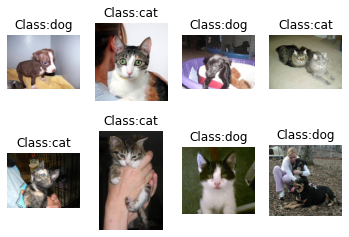

In [83]:
def num2cat(num):
  if num == 0:
    return 'cat'
  else:
    return 'dog'

predictions = model.predict(test_gen)
predictions = np.argmax(predictions,axis=1)


for i, file in enumerate(test_df['file'][:8]):
  img = imread(test_images_dir+file)  
  plt.subplot(2,4, i+1)
  plt.imshow(img)
  plt.title(f"Class:{num2cat(predictions[i])}")
  plt.axis('off')
  plt.imshow(img)

plt.show()